In [126]:
import json
import pandas as pd

# Data Wrangling
## Loading and processing the dataset

In [128]:
def load_data(csv_path, nrows=None):
    """
    Load and preprocess the Google Analytics customer revenue dataset.
    
    Parameters:
        csv_path (str): Path to the CSV file.
        nrows (int, optional): Number of rows to load for testing purposes. Loads all rows if None.
        
    Returns:
        pd.DataFrame: Processed DataFrame with flattened JSON columns and formatted data.
    """
    
    # Define columns that contain JSON data
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # Load the CSV file with JSON columns parsed and fullVisitorId as a string
    df = pd.read_csv(
        csv_path,
        converters={column: json.loads for column in JSON_COLUMNS},  # Convert JSON columns to dictionaries
        dtype={'fullVisitorId': 'str'},  # Ensure fullVisitorId is loaded as a string for uniqueness
        nrows=nrows  # Load specified number of rows if provided
    )
    
    # Flatten each JSON column and merge back into the main DataFrame
    for column in JSON_COLUMNS:
        # Convert JSON data in the column to a DataFrame
        column_as_df = pd.json_normalize(df[column])
        
        # Rename the columns to indicate their source (e.g., device_isMobile)
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        
        # Drop the original JSON column and merge the new flattened columns
        df = df.drop(column, axis=1).join(column_as_df)
    
    # Drop columns that are either not useful or too complex for initial analysis
    df.drop(columns=['customDimensions', 'hits'], inplace=True)
    
    # Fill missing values for key numerical columns with 0
    # - totals_pageviews: Number of pages viewed in a session, can be 0 if no pages were viewed
    # - totals_transactionRevenue: Revenue generated, fill missing with 0 as no revenue
    df.fillna({
        'totals_pageviews': 0,
        'totals_transactionRevenue': 0
    }, inplace=True)
    
    # Convert specific columns to integers for consistency
    df['device_isMobile'] = df['device_isMobile'].astype(int)  # Convert isMobile to 1 or 0
    df['totals_transactionRevenue'] = df['totals_transactionRevenue'].astype(int)  # Revenue as integer
    
    # Ensure all object (string) columns are consistently treated as strings
    cat_cols = df.select_dtypes(include='object').columns
    df[cat_cols] = df[cat_cols].astype(str)
    
    return df


In [130]:
# Load a subset (100,000 rows) of the data for testing purposes
df = load_data('../data/raw/dataset.csv', nrows=1000000)

# Inspect the first few rows to confirm the processing
display(df.head())

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,...,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_campaignCode
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,nan,nan,nan,nan,nan,nan,nan,nan
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,nan,True,nan,nan,nan,nan,nan,nan,nan
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [132]:
df.shape

(1000000, 58)

In [148]:
df.to_csv('../data/raw/readable_dataset.csv', index=False)

## Data Cleaning and Transformation

In [151]:
df['fullVisitorId'].head

<bound method NDFrame.head of 0         3162355547410993243
1         8934116514970143966
2         7992466427990357681
3         9075655783635761930
4         6960673291025684308
                 ...         
999995    3725326097124390672
999996    2158552115222657286
999997    8157991262626030554
999998    9963007161745063779
999999    8111333210792218028
Name: fullVisitorId, Length: 1000000, dtype: object>

In [144]:
df['fullVisitorId'].nunique()

814597

<br>

---
# Exploratory Data Analysis (EDA)

### Initial Data Overview

In [89]:
# Overview of data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 58 columns):
 #   Column                                             Non-Null Count    Dtype 
---  ------                                             --------------    ----- 
 0   channelGrouping                                    1000000 non-null  object
 1   date                                               1000000 non-null  int64 
 2   fullVisitorId                                      1000000 non-null  object
 3   socialEngagementType                               1000000 non-null  object
 4   visitId                                            1000000 non-null  int64 
 5   visitNumber                                        1000000 non-null  int64 
 6   visitStartTime                                     1000000 non-null  int64 
 7   device_browser                                     1000000 non-null  object
 8   device_browserVersion                              1000000 non-null  obje

In [90]:
# Summary statistics of numeric columns
df.describe()

,date,visitId,visitNumber,visitStartTime,device_isMobile,totals_transactionRevenue
count,1.000000e+06,1.000000e+06,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06
mean,2.016966e+07,1.497377e+09,2.315454,1.497377e+09,0.311362,1.325589e+06
std,6.541047e+03,1.634101e+07,9.210633,1.634101e+07,0.463051,4.613213e+07
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,0.000000,0.000000e+00
25%,2.016120e+07,1.480951e+09,1.000000,1.480951e+09,0.000000,0.000000e+00
50%,2.017062e+07,1.498168e+09,1.000000,1.498168e+09,0.000000,0.000000e+00
75%,2.017113e+07,1.511974e+09,1.000000,1.511974e+09,1.000000,0.000000e+00
max,2.018043e+07,1.525072e+09,457.000000,1.525072e+09,1.000000,2.312950e+10


In [91]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


### Distribution of `totals_transactionRevenue`

In [93]:
# Calculate total revenue per user
user_revenue = df.groupby('fullVisitorId')['totals_transactionRevenue'].sum()

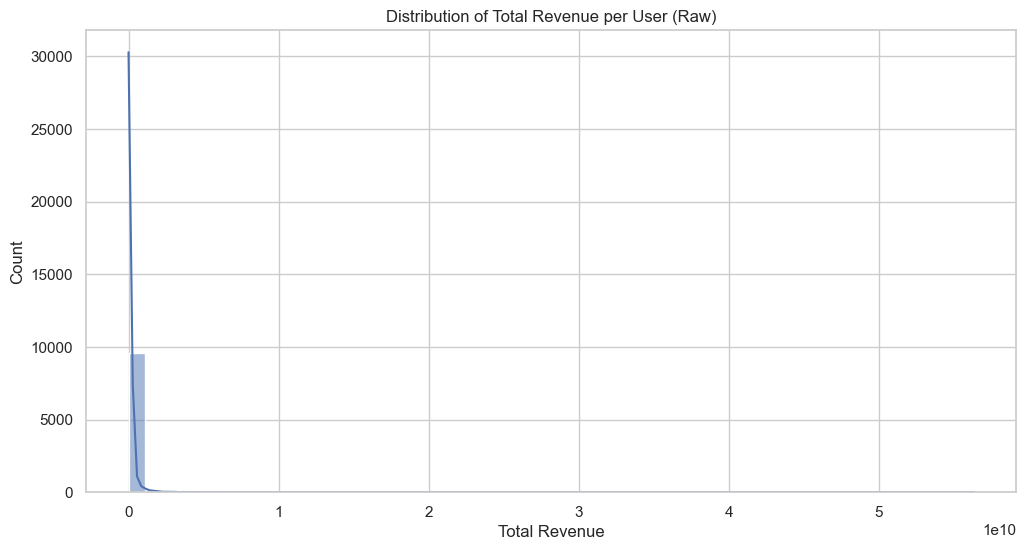

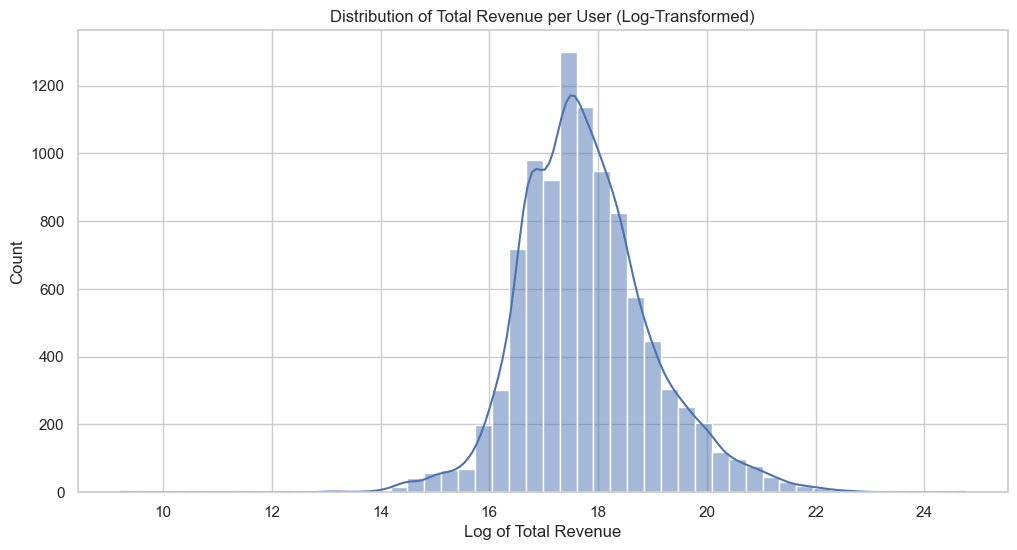

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Setting up seaborn for aesthetic plots
sns.set(style="whitegrid")

# Plot histogram of the total revenue
plt.figure(figsize=(12, 6))
sns.histplot(user_revenue[user_revenue > 0], bins=50, kde=True)
plt.title("Distribution of Total Revenue per User (Raw)")
plt.xlabel("Total Revenue")
plt.show()

# Plot histogram of log-transformed revenue
log_user_revenue = np.log1p(user_revenue[user_revenue > 0])
plt.figure(figsize=(12, 6))
sns.histplot(log_user_revenue, bins=50, kde=True)
plt.title("Distribution of Total Revenue per User (Log-Transformed)")
plt.xlabel("Log of Total Revenue")
plt.show()

#### Checking skewness and kurtosis

In [96]:
from scipy.stats import skew, kurtosis

print("\nSkewness of Raw Transaction Revenue:", skew(df['totals_transactionRevenue'].dropna()))
print("Kurtosis of Raw Transaction Revenue:", kurtosis(df['totals_transactionRevenue'].dropna()))
print("Skewness of Log-transformed Transaction Revenue:", skew(df['log_transactionRevenue'].dropna()))
print("Kurtosis of Log-transformed Transaction Revenue:", kurtosis(df['log_transactionRevenue'].dropna()))


Skewness of Raw Transaction Revenue: 265.72120506729357
Kurtosis of Raw Transaction Revenue: 107159.7471797566


KeyError: 'log_transactionRevenue'

#### Interpretation

##### Raw Transaction Revenue
**Skewness: 265.72**

- This extremely high positive skewness value indicates a very strong right skew. In other words, the distribution is heavily weighted toward lower values, with a long tail of very high revenue values.
Such high skewness is typical in e-commerce revenue data, where most users have low or zero revenue, and a few users contribute significantly more.

**Kurtosis: 107,159.75**

-This exceptionally high kurtosis value indicates extremely heavy tails, meaning that there are many extreme outliers (high-revenue users) in the data.
High kurtosis in the raw transaction revenue distribution shows that the distribution has far more extreme values than a normal distribution, which is often challenging for models to handle.
Together, these values tell us that the raw transaction revenue is highly skewed and has a large number of outliers, making it unsuitable for direct modeling.

<br>

##### Log-Transformed Transaction Revenue
**Skewness: 9.55**

- Although the skewness of the log-transformed revenue is still positive, it’s significantly lower than the skewness of the raw data. This reduction shows that log transformation has helped to reduce skewness, although some right skew still remains.

**Kurtosis: 89.57**

The kurtosis is still high but greatly reduced compared to the raw data. 
- This suggests that while there are still some extreme values, the distribution is less heavy-tailed after the log transformation.

### Revenue Analysis per User

In [ ]:
# Aggregate revenue per user, log-transform, and plot distribution
user_revenue = df.groupby('fullVisitorId')['totals_transactionRevenue'].sum()
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(user_revenue), bins=50, kde=True)
plt.title("Distribution of Total Revenue per User (Log-transformed)")
plt.xlabel("Log-transformed Total Revenue per User")
plt.ylabel("Frequency")
plt.show()

#### Interpretation
1. High Concentration at Zero or Near-Zero Revenue:

- The majority of users are clustered around a log-transformed revenue of close to zero. This means that most users have either zero revenue or very low total revenue.
- This distribution is common in e-commerce, where most customers may browse but not make a purchase, leading to a high frequency of low or zero revenue values.

In [ ]:
paying_user_revenue = user_revenue[user_revenue > 0]
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(paying_user_revenue), bins=50, kde=True)
plt.title("Distribution of Total Revenue per Paying User (Log-transformed)")
plt.xlabel("Log-transformed Total Revenue per User")
plt.ylabel("Frequency")
plt.show()

### Categorical Variable Analysis

#### Channel Grouping

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y='channelGrouping', data=df, order=df['channelGrouping'].value_counts().index)
plt.title("Distribution of Channel Grouping")
plt.xlabel("Count")
plt.ylabel("Channel Grouping")
plt.show()

<br>

#### Device Category

In [ ]:

plt.figure(figsize=(10, 5))
sns.countplot(y='device_deviceCategory', data=df, order=df['device_deviceCategory'].value_counts().index)
plt.title("Distribution of Device Category")
plt.xlabel("Count")
plt.ylabel("Device Category")
plt.show()

<br>

#### Country Distribution - Top 10 Countries by Visit Frequency

In [ ]:
top_countries = df['geoNetwork_country'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.countplot(y='geoNetwork_country', data=df[df['geoNetwork_country'].isin(top_countries)], 
              order=top_countries)
plt.title("Top 10 Countries by Visit Frequency")
plt.xlabel("Count")
plt.ylabel("Country")
plt.show()

<br>

#### Correlation matrix
Calculate and visualize correlation matrix for numerical columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()
